**_________Unet Model for trimap images of nucleus_____**

### Import Dependencies

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from imageio import imread
import imageio
import imageio.v3 as iio

import cv2

#### Dataset Path

In [2]:
TRAIN_PATH = 'C:/Users\Madina Computers/Documents/stage1_train/'

In [3]:
TEST_PATH = 'C:/Users\Madina Computers/Documents/stage1_test/'

In [4]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

#### image Dimension

In [5]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


In [6]:
train_ids

['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552',
 '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1',
 '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e',
 '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed',
 '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf',
 '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21',
 '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426',
 '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339',
 '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776',
 '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe',
 '03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a',
 '0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd',
 '04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e',
 '05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13',
 '0532c64c2fd0c4d3188cc751cdfd566b

In [7]:
len(train_ids)

670

In [8]:
#arrays of train data
X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

#label True and False for detection the objects in the frame
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [9]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = iio.imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = iio.imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    y[n] = mask 

Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [09:34<00:00,  1.17it/s]


### splitting the data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
# test images
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = iio.imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test_images[n] = img

print('Done!')

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:05<00:00, 12.89it/s]

Done!


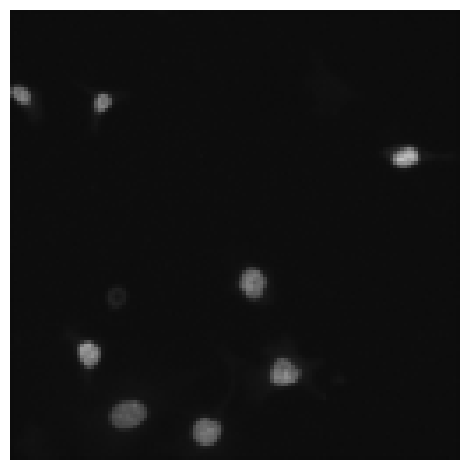

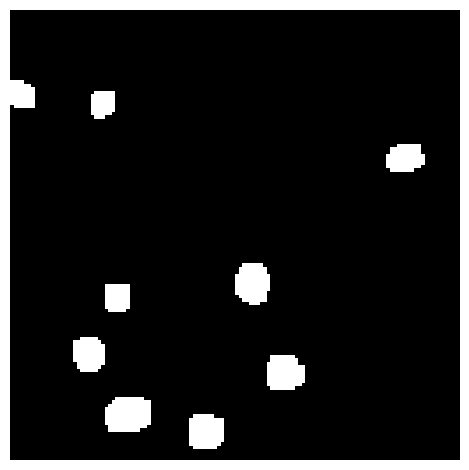

In [12]:
image_x = random.randint(0, len(X_train))
plt.axis("off")
imshow(X_train[image_x])
plt.show()
plt.axis("off")
imshow(np.squeeze(y_train[image_x]))
plt.show()


In [13]:
num_classes = 1

In [14]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

## Downsampling

In [15]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

### Upsampling

In [16]:
#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)


In [17]:
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

In [18]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 32, 32, 64)  65600       ['re_lu_5[0][0]']                
 spose)                                                                                           
                                                                                                  
 concatenate_1 (Concatenate)    (None, 32, 32, 128)  0           ['conv2d_transpose_1[0][0]',     
                                                                  'conv2d_5[0][0]']               
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 32, 32, 128)  512        ['concatenate_1[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 re_lu_6 (

In [21]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]


In [22]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
28/28 [==============================] - 66s 2s/step - loss: 0.5686 - accuracy: 0.7646 - val_loss: 0.7321 - val_accuracy: 0.7515
Epoch 2/25
28/28 [==============================] - 52s 2s/step - loss: 0.3464 - accuracy: 0.8826 - val_loss: 0.4446 - val_accuracy: 0.8834
Epoch 3/25
28/28 [==============================] - 51s 2s/step - loss: 0.2549 - accuracy: 0.9174 - val_loss: 0.3328 - val_accuracy: 0.9376
Epoch 4/25
28/28 [==============================] - 52s 2s/step - loss: 0.2033 - accuracy: 0.9341 - val_loss: 0.2261 - val_accuracy: 0.9419
Epoch 5/25
28/28 [==============================] - 51s 2s/step - loss: 0.1816 - accuracy: 0.9402 - val_loss: 0.1956 - val_accuracy: 0.9419
Epoch 6/25
28/28 [==============================] - 51s 2s/step - loss: 0.1661 - accuracy: 0.9442 - val_loss: 0.1478 - val_accuracy: 0.9576
Epoch 7/25
28/28 [==============================] - 51s 2s/step - loss: 0.1445 - accuracy: 0.9500 - val_loss: 0.1347 - val_accuracy: 0.9577
Epoch 8/25
28/28 [==

In [23]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']



In [32]:
print('training loss :',loss)
print('validation loss :',val_loss)

training loss : [0.568559467792511, 0.3464086651802063, 0.25488558411598206, 0.20330928266048431, 0.18161967396736145, 0.16613268852233887, 0.14446114003658295, 0.13990750908851624, 0.13074004650115967, 0.1272672563791275, 0.11847320944070816, 0.11123389005661011, 0.11114624887704849, 0.11282898485660553, 0.10820721089839935, 0.10424651205539703, 0.09922067821025848, 0.10135101526975632, 0.099286749958992, 0.09549231827259064, 0.09426538646221161]
validation loss : [0.7321051955223083, 0.4446040689945221, 0.33283188939094543, 0.2261224240064621, 0.1955888569355011, 0.1477971225976944, 0.13471484184265137, 0.13580434024333954, 0.12258699536323547, 0.11901167035102844, 0.1115918830037117, 0.1136513501405716, 0.11005145311355591, 0.11244302242994308, 0.0971200168132782, 0.1012788787484169, 0.09691229462623596, 0.10897677391767502, 0.09159213304519653, 0.09422885626554489, 0.09379427880048752]


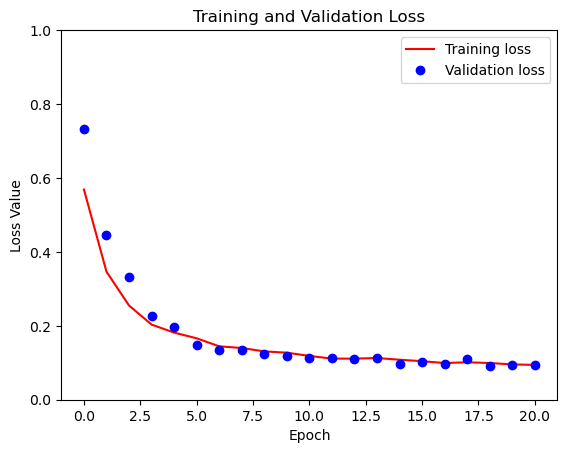

In [33]:
plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [24]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

In [25]:
print('training accuracy :',accuracy)
print('validation accuracy :',val_accuracy)

training accuracy : [0.7645842432975769, 0.8826070427894592, 0.917388379573822, 0.9341254830360413, 0.940150260925293, 0.9441788792610168, 0.9499728083610535, 0.9507855176925659, 0.9537554979324341, 0.9540612101554871, 0.9571303129196167, 0.9590794444084167, 0.958856463432312, 0.9580748677253723, 0.9590253829956055, 0.9607537388801575, 0.9625468850135803, 0.9615102410316467, 0.9622832536697388, 0.9633435010910034, 0.9637495875358582]
validation accuracy : [0.7514552474021912, 0.8834376931190491, 0.937592089176178, 0.9418931603431702, 0.9419434666633606, 0.9576044678688049, 0.957680344581604, 0.9556562900543213, 0.9601588845252991, 0.9605119228363037, 0.9624592661857605, 0.9609748721122742, 0.9625241160392761, 0.9599241018295288, 0.9655899405479431, 0.9650626182556152, 0.966072678565979, 0.9613919854164124, 0.9665225148200989, 0.9656399488449097, 0.9660666584968567]


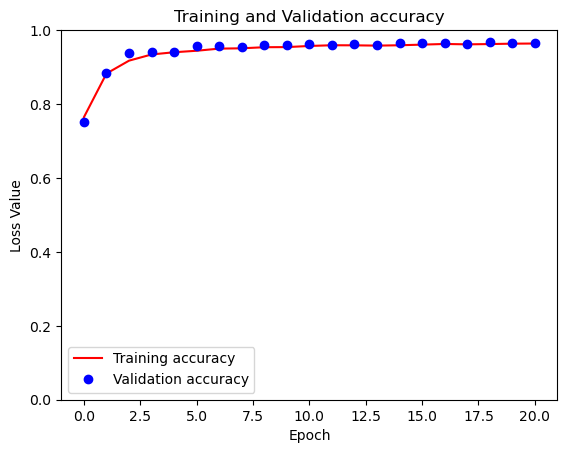

In [26]:
plt.figure()
plt.plot( accuracy, 'r', label='Training accuracy')
plt.plot( val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Function to display an orignal image ,orignal mask of image and predicted mask

In [27]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [28]:
i = random.randint(0, len(X_test))
sample_image = X_test[i]
sample_mask = y_test[i]

In [29]:
prediction = model.predict(sample_image[tf.newaxis, ...])[0]

1/1 [==============================] - 1s 626ms/step


In [30]:
predicted_mask = (prediction > 0.9).astype(np.uint8)

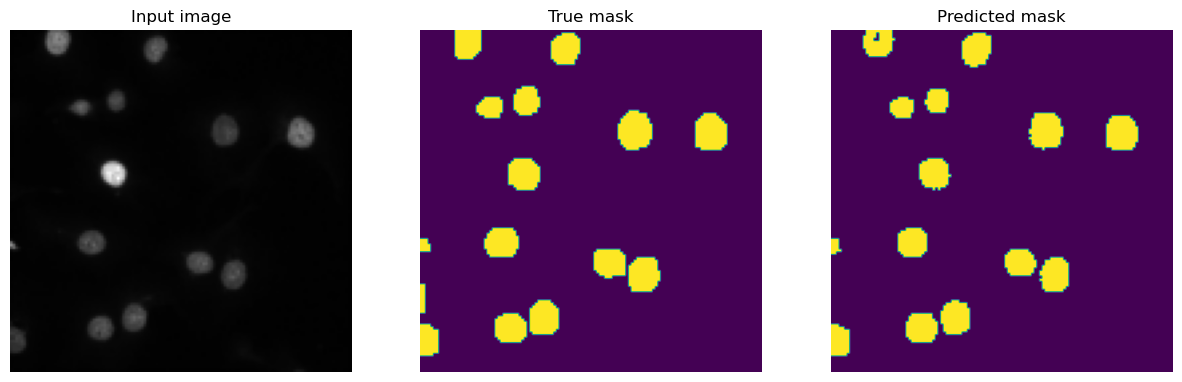

In [31]:
display([sample_image, sample_mask,predicted_mask])


#### Hence unet model predicting very well against orignal mask and image of trimap image dataset